# Loads the processed h5 file and plots data

In [5]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [6]:
# input parameters
temperature = {
              '08 mm' : (250.  + 252.)  / 2,
              '20 mm' : (238.3 + 239.9) / 2,
              '28 mm' : (234.7 + 236.3) / 2,
              '35 mm' : (232.6 + 234.1) / 2,
              '40 mm' : (231.4 + 232.8) / 2,
              '45 mm' : (231.9 + 230.4) / 2,
              '50 mm' : (230.8 + 229.5) / 2,
              '55 mm' : (228.7 + 230)   / 2,
              '60 mm' : (228   + 229.3) / 2,
              '65 mm' : (227.4 + 228.6) / 2,
              '70 mm' : (226.8 + 228.1) / 2,
              '75 mm' : (226.3 + 227.5) / 2,
              '80 mm' : (225.8 + 227)   / 2,
              '85 mm' : (225.4 + 226.6) / 2}

    
run_groups = { # all 300 uJ data
              '08 mm' : [200],
              '20 mm' : [196],
              '28 mm' : [109, 110, 111, 113],
              '35 mm' : [115,116,119,121,122,123],
              '40 mm' : [124,125,126],
              '45 mm' : [127,128,129,131,179,180,181],
              '50 mm' : [133,134,135,136,137,182,183],
              '55 mm' : [138,139,140,141,142,143],
              '60 mm' : [145,146,147,149,220],
              '65 mm' : [150,151,152,153,154,155,156,214,215,216],
              '70 mm' : [157,158,159,160,161,162,177,178,201,202,203,204,217,218,219],
              '75 mm' : [165,166,167,168,169,170,184,185,186,187,188,189,190,191,192,193,194,195],
              '80 mm' : [171,172,173,205,206,207,208,209,210,211,212,213],
              '85 mm' : [174,175,176]}    



### load and analyse data

In [7]:
def analyse_multiple_runs(run_num_list, detector_distance = 0.1249, photon_energy = 9.5, iq_thr = 1., ice_thr = 1., filter_length = 1, xray_i0_thr = 2, laser_i0_thr = 3):
    '''
    loads a single run into a list for all runs in the same run group (i.e. nozzle distance)
    performs the following analysis on all shots from one run group:
        - calculates q_scale (mean, not single shot)
        - normalizes by i0 (single shot)
        - finds water hits and ice hits
        - calculates hitrate based on logic: misses, water hits and ice hits are mutually exclusive
        - subtracts background from hits
        - calculates water hit average
        - calculates water hit diffference between laser on and laser off
    parameters:
        - detector_distance [m], sample-detector distance
        - photon_energy [keV], average photon energy (shot-to-shot variations not included in analysis)
        - iq_thr [photon/pix/], threshold for average intensity in i0-corrected I(q), limits set by r_min, r_max
        - ice_thr [photon/pix], threshold for maximum gradient in i0-corrected I(q), limits set by q_min, q_max
        - filter_length [number of bins], bins for median filter, 1 = filter off
        - xray_i0_thr [number of std], lower end threshold for x-ray intensities
        - laser_i0_thr [number of std], upper and lower end threshold for laser intensities
    '''
    
    # parameters
    q_min, q_max  = 1.0, 4.5 # A-1
    r_min, r_max  = 200, 400 # bins
    
    # load data
    img      = np.zeros(( 4432, 4215 )) # average 2d image of run
    img_hits = np.zeros(( 4432, 4215 )) # average 2d image of hits in run
    nshots   = 0                        # total for the whole run group
    # assume r does not change run to run
    Iq       = []                       # (shots, q_bins)
    i0       = []                       # (shots) mean in ROI
    laser_i0 = []                       # (shots) mean in ROI
    laser_on = []                       # (shots) boolean value (True = on)
    
    for run_num in run_num_list:
        
        # r_ prefix indicates per-run data
        try:
            run_path = '/sf/bernina/data/p17743/res/work/hdf5/'
            run = discover_run_h5(run_num, path=run_path)[3:-3]
            r_img, r_Iq, r, r_nshots, r_img_hits, thr, r_nhits, r_i0, r_laser_i0, r_laser_on, r_event_ID = load_processed_data(run, path=run_path)
        except (OSError, KeyError) as e:
            print(run_num, e)
            
        img       += r_img
        Iq.append(r_Iq)
        nshots    += r_nshots
        img_hits  += img_hits
        i0.append(r_i0)
        laser_i0.append(r_laser_i0)
        laser_on.append(r_laser_on)
            
    # finally, vstack the arrays so they appear like they came from one dataset (run)
    Iq       = np.vstack(Iq)
    i0       = np.concatenate(i0)
    laser_i0 = np.concatenate(laser_i0)
    laser_on = np.concatenate(laser_on)
        
    # >>>> now proceed with the analysis of run-aggregated data
    
    # convert q_scale
    q = q_scale(r, detector_distance=detector_distance, photon_energy=photon_energy*1000.0)

    # convert intensity to photon/pix
    Iq /= photon_energy
    i0 /= photon_energy
    
    # normalise to i0
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    Iq_norm = Iq[:,:] / norm[:,None]
    
    # find hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=r_min,r_max=r_max)
    
    #find ice
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)
    # exclude ice hits
    hits *= np.logical_not(ice_hits)
    
    # weak hit rejection
    misses = np.logical_not(hits) & (i0 > i0_avg - xray_i0_thr*i0.std()) # remove weak x-ray shots
    hits = hits & (i0 > i0_avg - xray_i0_thr*i0.std()) # remove weak x-ray shots
    
    # weak laser rejection
    l = laser_i0[laser_on.astype(np.bool)][:nshots]
    laser_outliers = laser_on.astype(np.bool) & ((laser_i0 > (l.mean() + laser_i0_thr*l.std())) | (laser_i0 < (l.mean() - laser_i0_thr*l.std())))
    hits *= np.logical_not(laser_outliers)
    
    # subtract background
    Iq_corr = subtract_background(Iq,hits,i0,nshots,misses=misses) # Iq_corr same shape as Iq[hits]
    
    # average hits
    if Iq_corr is not None:
        hit_avg = np.average(Iq_corr,axis=0)
    else:
        hit_avg = np.zeros_like(np.average(Iq,axis=0))
    
    # pump probe (new method)
    diff_signal = pump_probe_signal_2(Iq_corr,hits,laser_on,r_min=200,r_max=400)
    
    return {'q':              q,
            'Iq_water':       hit_avg,
            'Iq_water_diff':  diff_signal, 
            'water_hits':     hits.sum(), 
            'laseron_hits':   (hits & laser_on).sum(), 
            'ice_hits':       ice_hits.sum(), 
            'total_shots':    nshots}

### run

In [8]:
run_means = {}
for rg in run_groups.keys():
    print("---------- %s ----------" % rg)
    run_means[rg] = analyse_multiple_runs(run_groups[rg])

---------- 08 mm ----------
run0200_droplets_10um_7p5mm: 17998 shots
---------- 20 mm ----------
run0196_droplets_10um_20mm: 17998 shots
---------- 28 mm ----------
run0109_droplets_10um_28mm: 18000 shots
run0110_droplets_10um_28mm: 17998 shots
run0111_droplets_10um_28mm: 17998 shots
run0113_droplets_10um_28mm: 17998 shots
---------- 35 mm ----------
run0115_droplets_10um_35mm: 17998 shots
run0116_droplets_10um_35mm: 17998 shots
run0119_droplets_10um_35mm: 17998 shots
run0121_droplets_10um_35mm: 17998 shots
run0122_droplets_10um_35mm: 17998 shots
run0123_droplets_10um_35mm: 17998 shots
---------- 40 mm ----------
run0124_droplets_10um_35mm: 17998 shots
run0125_droplets_10um_40mm: 17998 shots
run0126_droplets_10um_40mm: 17998 shots
---------- 45 mm ----------
run0127_droplets_10um_45mm: 17998 shots
run0128_droplets_10um_45mm: 17998 shots
run0129_droplets_10um_45mm: 17998 shots
run0131_droplets_10um_45mm: 17998 shots
run0179_droplets_10um_45mm: 17998 shots
run0180_droplets_10um_45mm: 179

### plot

<IPython.core.display.Javascript object>


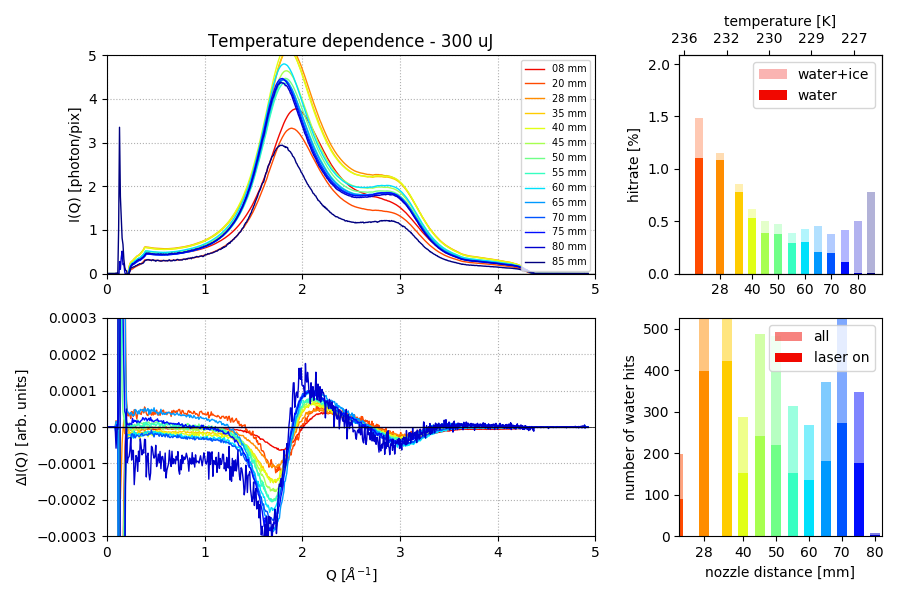

In [9]:
col = plt.cm.jet(np.linspace(0., 0.9, len(run_means.keys())))[::-1]

plt.figure(figsize=[9,6])

plt.subplot2grid((2,3),(0,0),colspan=2)
plt.title('Temperature dependence - 300 uJ')

for n,rg in enumerate(run_means.keys()):
    q    = run_means[rg]['q']
    hit  = run_means[rg]['Iq_water']
    plt.plot(q, hit, label=rg, lw=1, color=col[n]) # hit Iq is bg subtracted

plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.ylim(0,5)
plt.grid(linestyle='dotted')

plt.subplot2grid((2,3),(1,0),colspan=2)
for n,rg in enumerate(run_means.keys()):
    plt.plot(q, run_means[rg]['Iq_water_diff'], label=rg, lw=1, color=col[n])
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.ylim(-3e-4, 3e-4)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)

plt.subplot2grid((2,3),(0,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), 
            (run_means[rg]['water_hits'] + run_means[rg]['ice_hits']) * 100./run_means[rg]['total_shots'], 
            width=3, alpha=0.3, color=col[n])
    plt.bar(int(rg[:2]), 
            run_means[rg]['water_hits'] * 100./run_means[rg]['total_shots'], 
            width=3, color=col[n])
    
plt.legend(['water+ice', 'water'])
plt.ylabel('hitrate [%]')
#plt.xlabel('nozzle distance [mm]')


d = [int(rg[:2]) for rg in run_means.keys()]
ax1 = plt.gca()
ax1.xaxis.set_ticks(d[::2])

T = ["%.0f" % temperature[rg] for rg in run_means.keys()]
ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
plt.locator_params(axis='x', nbins=len(T[::2]))
ax2.xaxis.set_major_formatter(plt.FixedFormatter(T[::2]))
ax2.set_xlabel('temperature [K]')

plt.subplot2grid((2,3),(1,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), run_means[rg]['water_hits'], width=3, alpha=0.5, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg]['laseron_hits'], width=3, color=col[n])
plt.legend(['all', 'laser on'])
plt.ylabel('number of water hits')
plt.xlabel('nozzle distance [mm]')
ax1 = plt.gca()
ax1.xaxis.set_ticks(d[::2])


plt.tight_layout()
plt.savefig('master_plot_diff_signal_cleaned.png')
plt.show()